# LSTM Prediction for the Unemployment rate of California

writen by Duo

## Setting

In [1]:
import numpy as np
import pandas as pd
import warnings
import random

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.autograd import Variable

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import pmdarima as pm

from prophet import Prophet

C:\Users\Claus\AppData\Roaming\Python\Python39\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.deterministic = True

setup_seed(20)

In [3]:
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format
warnings.filterwarnings('ignore')

In [4]:
if (torch.cuda.is_available()):
    device = torch.device("cuda:0")
    print('Training on GPU.')
else:
    device = torch.device("cpu")
    print('No GPU available, training on CPU.')

Training on GPU.


# Tuning Paramaters

In [5]:
INPUT_FEATURES_NUM = 5
OUTPUT_FEATURES_NUM = 1
LEARNING_RATE = 0.01
PREV_LOSS = 1000
MAX_EPOCHS = 2000

## Dataset


In [6]:
def getfile(location_pair,**kwargs): #tries to get local version and then defaults to google drive version
    (loc,gdrive)=location_pair
    try:
        out=pd.read_csv(loc,**kwargs)
    except FileNotFoundError:
        print("local file not found; accessing Google Drive")
        loc = 'https://drive.google.com/uc?export=download&id='+gdrive.split('/')[-2]
        out = pd.read_csv(loc,**kwargs)
    return out


fname=("Local_Area_Unemployment_Statistics__LAUS_.csv","https://drive.google.com/file/d/1xoDHEKiN-y4QyZNET8SdlVRSsgW_7TLy/view?usp=sharing")
data=getfile(fname)

local file not found; accessing Google Drive


In [7]:
data['Date']= pd.to_datetime(data['Date'])
data['ts'] = data.Date.values.astype(np.int64) # convert datetime to pandas timestamps
data['Employment Rate']=data['Employment ']/data['Labor Force']
data.columns = ['Area Type', 'Area Name', 'Date', 'Year', 'Month',
       'Seasonally Adjusted (Y/N)', 'Status (Preliminary / Final)',
       'Labor Force', 'Employment', 'Unemployment', 'Unemployment Rate','ts','Employment Rate']
cat_col = ['Area Type', 'Area Name','Seasonally Adjusted (Y/N)', 'Status (Preliminary / Final)']
time_col = ['Date', 'Year', 'Month']
num_col = ['Labor Force', 'Employment', 'Unemployment', 'Unemployment Rate', 'ts', 'Employment Rate']

In [8]:
data.head()

,Area Type,Area Name,Date,Year,Month,Seasonally Adjusted (Y/N),Status (Preliminary / Final),Labor Force,Employment,Unemployment,Unemployment Rate,ts,Employment Rate
0,State,California,1976-01-01,1976,January,N,Final,9672362,8668016,1004346,0.10,189302400000000000,0.90
1,State,California,1976-01-01,1976,January,Y,Final,9774280,8875685,898595,0.09,189302400000000000,0.91
2,County,Los Angeles County,1976-01-01,1976,January,N,Final,3364151,3040058,324093,0.10,189302400000000000,0.90
3,County,Los Angeles County,1976-01-01,1976,January,Y,Final,3381856,3081806,300050,0.09,189302400000000000,0.91
4,Metropolitan Area,Los Angeles-Long Beach-Glendale MD,1976-01-01,1976,January,N,Final,3364151,3040058,324093,0.10,189302400000000000,0.90


In [9]:
data["Area Name"].value_counts()

California                            1122
Los Angeles-Long Beach-Glendale MD    1122
Los Angeles County                    1122
Tuolumne County                        393
Hanford-Corcoran MSA                   393
                                      ... 
Hawaiian Gardens city                  153
Hawthorne city                         153
Hayfork CDP                            153
Hayward city                           153
Lakewood city                          153
Name: Area Name, Length: 1050, dtype: int64

In [10]:
data["Area Name"].unique()

array(['California', 'Los Angeles County',
       'Los Angeles-Long Beach-Glendale MD', ...,
       'Vallejo-Fairfield, CA MSA', 'Visalia-Porterville, CA MSA',
       'Yuba City, CA MSA'], dtype=object)

## Data Processing

In [11]:
def Area_chosen(place = 'California', index = True):
    df = data.loc[(data['Area Name'] == place)]
    df = df.loc[(df['Seasonally Adjusted (Y/N)']=='N')]
    df = df.loc[(df['Status (Preliminary / Final)']=='Final')]
    df = df[['Date', 'Unemployment Rate']]
    if index == True:
        df.set_index(["Date"], inplace=True)
    df = df.sort_index(ascending=True)
    order = []
    for i in range(INPUT_FEATURES_NUM + 1):
        j = 'R-' + str(i)
        df[j] = df['Unemployment Rate'].shift(i)
        order.append(j)
    order.reverse()
    df = df.dropna()
    df = df[order]
    return df

In [12]:
city = 'California' # chose your city in california or see the data of all state
df = Area_chosen(city)

In [13]:
S = StandardScaler()
Ss = S.fit_transform(df)
Ss = Ss.astype('float32')

y = Ss[:,-1]
X = np.delete(Ss,-1,axis=1)
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, shuffle = False)

train_x_tensor = train_x.reshape(-1, 1, INPUT_FEATURES_NUM)  # set batch size to 1
train_y_tensor = train_y.reshape(-1, 1, OUTPUT_FEATURES_NUM)  # set batch size to 1
 
train_x_tensor = torch.from_numpy(train_x_tensor).to(device)
train_y_tensor = torch.from_numpy(train_y_tensor).to(device)

## Arima Model

In [14]:
arima = pm.auto_arima(train_y, error_action='ignore', trace=True,
                      suppress_warnings=True, maxiter=5,
                      seasonal=True, m=12)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-696.499, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-196.033, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-635.514, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-397.755, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-198.032, Time=0.04 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=-400.211, Time=0.17 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=-642.713, Time=0.24 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=-692.872, Time=0.81 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=-650.653, Time=1.00 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=-195.106, Time=0.06 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=-471.845, Time=0.61 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=-679.041, Time=0.70 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=-689.699, Time=0.93 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=-669.373, Time=0.25 sec
 ARIMA(2,1,1)(1,0,1

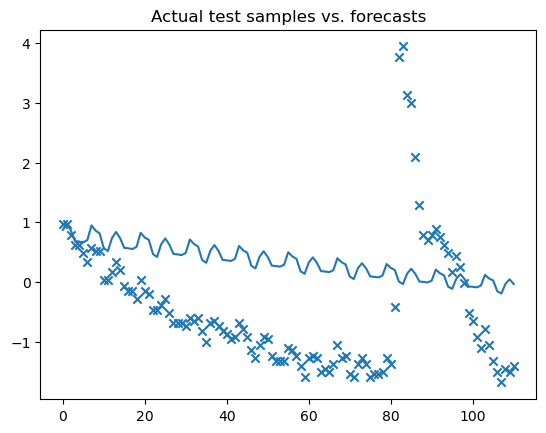

MSE Loss of Arima is 4030.597896589552


In [15]:
x_arima = np.arange(test_y.shape[0])
y_arima = arima.predict(n_periods=test_y.shape[0])
loss_arima = mean_squared_error(x_arima, y_arima)
plt.scatter(x_arima, test_y, marker='x')
plt.plot(x_arima, y_arima)
plt.title('Actual test samples vs. forecasts')
plt.show()
print(f"MSE Loss of Arima is {loss_arima}")

## Prophet Model

In [16]:
ph_date = df.reset_index()['Date']
ph_train = pd.DataFrame({'ds':ph_date.iloc[0:len(train_y)], 'y':train_y})
ph_test = pd.DataFrame({'ds':ph_date.iloc[len(train_y):], 'y':test_y})

In [17]:
ph_model = Prophet()
ph_model.fit(ph_train)

00:24:38 - cmdstanpy - INFO - Chain [1] start processing
00:24:38 - cmdstanpy - INFO - Chain [1] done processing


In [18]:
forecast = ph_model.predict(ph_test)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
loss_ph = mean_squared_error(ph_test['y'], forecast['yhat'])
print(f"MSE Loss of Prophet is {loss_ph}")


MSE Loss of Prophet is 7.5211954324022985


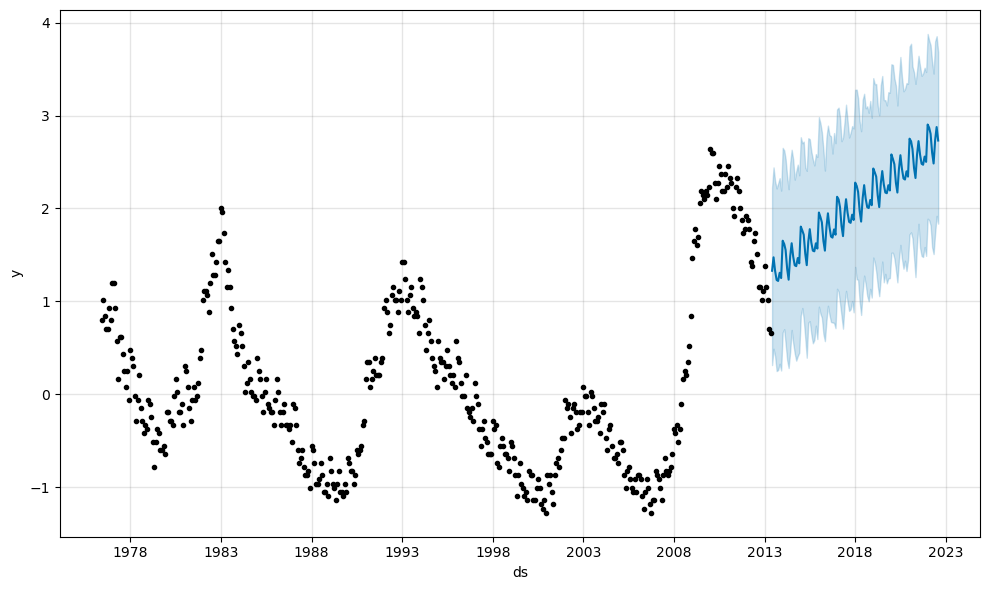

In [19]:
fig1 = ph_model.plot(forecast)


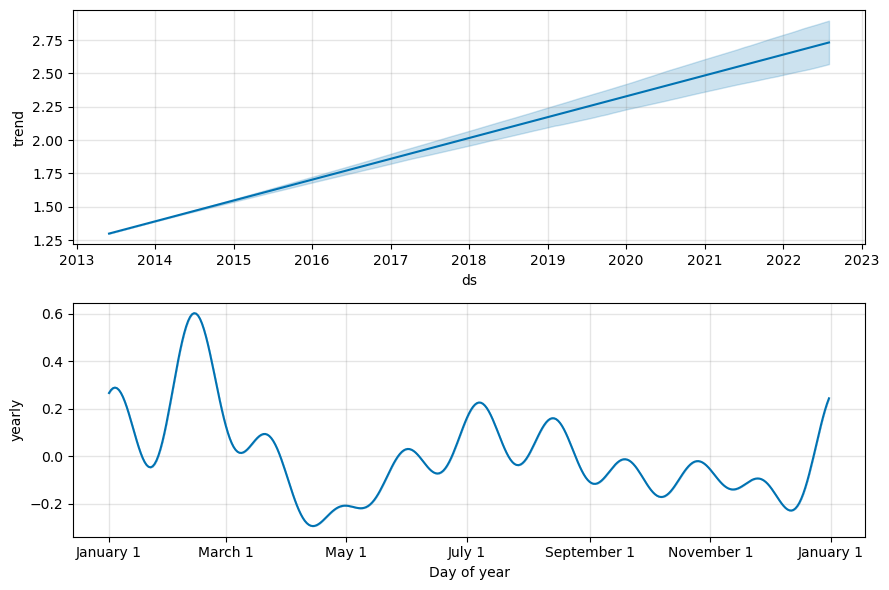

In [20]:
fig2 = ph_model.plot_components(forecast)


## LSTM Model

In [21]:
class LstmRNN(nn.Module):
    """
        Parameters：
        - input_size: feature size
        - hidden_size: number of hidden units
        - output_size: number of output
        - num_layers: layers of LSTM to stack
    """
 
    def __init__(self, input_size, hidden_size=1, output_size=1, num_layers=1):
        super().__init__()
 
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers)  # utilize the LSTM model in torch.nn
        self.linear1 = nn.Linear(hidden_size, output_size) #
 
    def forward(self, _x):
        x, _ = self.lstm(_x) # _x is input, size (seq_len, batch, input_size)
        s, b, h = x.shape  # x is output, size (seq_len, batch, hidden_size)
        x = x.view(s * b, h)
        x = self.linear1(x)
        x = x.view(s, b, -1)
        return x



In [22]:
def lossFunction(evaluation = 'MSE'):
    if evaluation == 'Huber':
        criterion = nn.HuberLoss()
    elif evaluation == 'SmoothL1':
        criterion = nn.SmoothL1Loss()
    else:
        criterion = nn.MSELoss()
    return criterion

#loss_function = lossFunction(evaluation = 'MSE')

In [23]:
def train(loss_function, opt, prev_loss = PREV_LOSS, max_epochs = MAX_EPOCHS):
    
    lstm_model = LstmRNN(INPUT_FEATURES_NUM, 20, output_size=OUTPUT_FEATURES_NUM, num_layers=1).to(device)  # 20 hidden units
    
    if opt == 'Adagrad':
        optimizer = torch.optim.Adam(lstm_model.parameters(), lr=LEARNING_RATE)
    elif opt == 'SGD':
        optimizer = torch.optim.SGD(lstm_model.parameters(), lr=LEARNING_RATE)
    else:
        optimizer = torch.optim.Adam(lstm_model.parameters(), lr=LEARNING_RATE)
 
    prev_loss = PREV_LOSS
    max_epochs = MAX_EPOCHS    
    
    lstm_model.train()
    for epoch in range(max_epochs):
        output = lstm_model(train_x_tensor)
        loss = loss_function(output, train_y_tensor)
 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
 
        if loss < prev_loss:
            #torch.save(lstm_model.state_dict(), f'lstm_model_{city}.pt')  # save model parameters to files
            prev_loss = loss
 
        if loss.item() < 1e-4:
            print('Epoch [{}/{}], Loss: {:.5f}'.format(epoch + 1, max_epochs, loss.item()))
            print("The loss value is reached")
            break
        elif (epoch + 1) % 100 == 0:
            print('Epoch: [{}/{}], Loss:{:.5f}'.format(epoch + 1, max_epochs, loss.item()))
    
    return lstm_model

In [24]:
def evaluation(loss_function, lstm_model):

    pred_y_for_train = lstm_model(train_x_tensor).to(device)
    pred_y_for_train = pred_y_for_train.cpu().view(-1, OUTPUT_FEATURES_NUM).data.numpy()

    lstm_model = lstm_model.eval()  # switch to testing model
 
    test_x_tensor = test_x.reshape(-1, 1,
                                   INPUT_FEATURES_NUM)
    test_x_tensor = torch.from_numpy(test_x_tensor)  
    test_x_tensor = test_x_tensor.to(device)
 
    pred_y_for_test = lstm_model(test_x_tensor)
    pred_y_for_test = pred_y_for_test.cpu().view(-1, OUTPUT_FEATURES_NUM).data.numpy()

    loss = loss_function(torch.from_numpy(pred_y_for_test), torch.from_numpy(test_y))
    print("test loss:", loss.item())
    return pred_y_for_train, pred_y_for_test

## Model Viz

In [25]:
def viz(evaluation, train_y = train_y):
    pred_y_for_train, pred_y_for_test = evaluation
    plt.figure()
    plt.plot(range(len(train_y)), train_y, 'b', label='y_trn')
    plt.plot(range(len(train_y)), pred_y_for_train, 'y--', label='pre_trn')
 
    plt.plot(range(len(train_y),len(train_y)+len(test_y)), test_y, 'k', label='y_tst')
    plt.plot(range(len(train_y),len(train_y)+len(test_y)), pred_y_for_test, 'm--', label='pre_tst')
 
    plt.xlabel('t')
    plt.ylabel('Rate')
    plt.show()


## Effectiveness Comparison of Multiple Loss Functions


Epoch: [100/2000], Loss:0.02967
Epoch: [200/2000], Loss:0.02417
Epoch: [300/2000], Loss:0.01793
Epoch: [400/2000], Loss:0.01323
Epoch: [500/2000], Loss:0.00939
Epoch: [600/2000], Loss:0.00739
Epoch: [700/2000], Loss:0.00349
Epoch: [800/2000], Loss:0.00284
Epoch: [900/2000], Loss:0.00267
Epoch: [1000/2000], Loss:0.00681
Epoch: [1100/2000], Loss:0.00217
Epoch: [1200/2000], Loss:0.00167
Epoch: [1300/2000], Loss:0.00138
Epoch: [1400/2000], Loss:0.00110
Epoch: [1500/2000], Loss:0.00206
Epoch: [1600/2000], Loss:0.00079
Epoch: [1700/2000], Loss:0.00067
Epoch: [1800/2000], Loss:0.00067
Epoch: [1900/2000], Loss:0.00053
Epoch: [2000/2000], Loss:0.00046
test loss: 1.9388362169265747


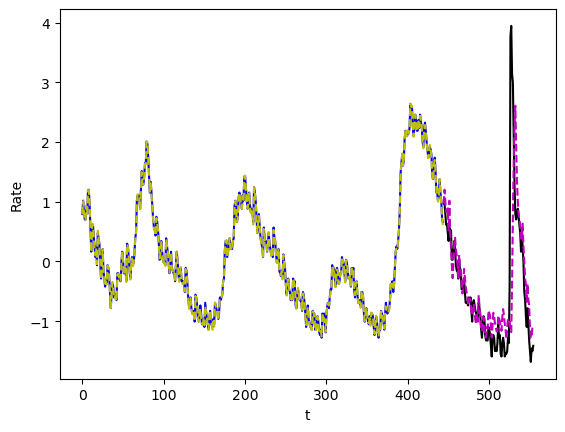

In [26]:
loss_function = lossFunction('MSE')
t = train(loss_function, 'Adam')
e = evaluation(loss_function, t)
viz(e)

Epoch: [100/2000], Loss:0.13582
Epoch: [200/2000], Loss:0.09399
Epoch: [300/2000], Loss:0.08736
Epoch: [400/2000], Loss:0.08199
Epoch: [500/2000], Loss:0.07737
Epoch: [600/2000], Loss:0.07335
Epoch: [700/2000], Loss:0.06984
Epoch: [800/2000], Loss:0.06672
Epoch: [900/2000], Loss:0.06394
Epoch: [1000/2000], Loss:0.06143
Epoch: [1100/2000], Loss:0.05918
Epoch: [1200/2000], Loss:0.05715
Epoch: [1300/2000], Loss:0.05532
Epoch: [1400/2000], Loss:0.05369
Epoch: [1500/2000], Loss:0.05224
Epoch: [1600/2000], Loss:0.05095
Epoch: [1700/2000], Loss:0.04983
Epoch: [1800/2000], Loss:0.04884
Epoch: [1900/2000], Loss:0.04799
Epoch: [2000/2000], Loss:0.04725
test loss: 2.097055196762085


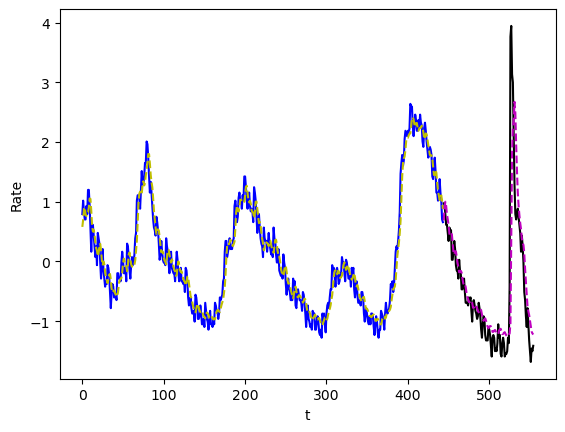

In [27]:
loss_function = lossFunction('MSE')
t = train(loss_function, 'SGD')
e = evaluation(loss_function, t)
viz(e)

Epoch: [100/2000], Loss:0.03054
Epoch: [200/2000], Loss:0.02232
Epoch: [300/2000], Loss:0.01866
Epoch: [400/2000], Loss:0.02492
Epoch: [500/2000], Loss:0.00826
Epoch: [600/2000], Loss:0.00533
Epoch: [700/2000], Loss:0.02388
Epoch: [800/2000], Loss:0.01883
Epoch: [900/2000], Loss:0.01524
Epoch: [1000/2000], Loss:0.01032
Epoch: [1100/2000], Loss:0.00724
Epoch: [1200/2000], Loss:0.00621
Epoch: [1300/2000], Loss:0.00424
Epoch: [1400/2000], Loss:0.00305
Epoch: [1500/2000], Loss:0.00310
Epoch: [1600/2000], Loss:0.02162
Epoch: [1700/2000], Loss:0.01591
Epoch: [1800/2000], Loss:0.01256
Epoch: [1900/2000], Loss:0.00920
Epoch: [2000/2000], Loss:0.00632
test loss: 2.1621148586273193


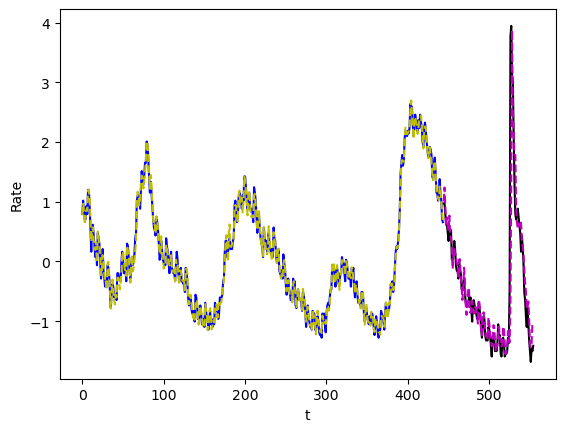

In [28]:
loss_function = lossFunction('MSE')
t = train(loss_function, 'Adagrad')
e = evaluation(loss_function, t)
viz(e)